In [16]:
import os, sys
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm
from collections import defaultdict
import random

In [18]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility/src')
sys.path.append(PATH)
from lib.file_location import DATA_PATH

color_radius = 3
animal = 'MD585'
ATLAS = 'atlasV8'
CSVPATH = os.path.join(DATA_PATH, 'atlas_data', ATLAS, animal)
jsonpath = os.path.join(CSVPATH,  'aligned_structure_sections.json')
with open(jsonpath) as f:
    aligned_dict = json.load(f)

In [3]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [19]:
structure = random.choice(list(aligned_dict.keys()))
structure = 'SC'

In [20]:
onestructure = aligned_dict[structure]

In [6]:
mins = []
maxs = []

for index, points in onestructure.items():
    arr_tmp = np.array(points)
    min_tmp = np.min(arr_tmp, axis=0)
    max_tmp = np.max(arr_tmp, axis=0)
    mins.append(min_tmp)
    maxs.append(max_tmp)

In [21]:
minx = []
miny = []
maxx = []
maxy = []
xss = []
for index, points in onestructure.items():
    x1 = min([i[0] for i in points])
    y1 = min([i[1] for i in points])
    minx.append(x1)
    miny.append(y1)
    x2 = max([i[0] for i in points])
    y2 = max([i[1] for i in points])
    maxx.append(x2)
    maxy.append(y2)
    
print(min(minx), max(maxx))
print(min(miny), max(maxy))

642.9523649617493 789.4131251237085
178.5386805468183 387.3451709400767


In [8]:
sections = [int(i) for i in onestructure.keys()]
zlength = (max(sections) - min(sections))
min_xy = np.min(mins, axis=0)
min_x = min_xy[0]
min_y = min_xy[1]
max_xy = np.max(maxs, axis=0)
max_x = max_xy[0]
max_y = max_xy[1]
xlength = max_x - min_x
ylength = max_y - min_y

In [9]:
print(zlength, int(xlength), int(ylength))
print(int(min_x), int(max_x))
print(int(min_y), int(max_y))

172 134 135
710 845
205 340


In [10]:
section = random.choice(sections)
points = onestructure[str(section)]
arr = np.array(np.round(points)).astype(np.int32)
np.mean(arr, axis=0)

array([770.81927711, 252.34939759])

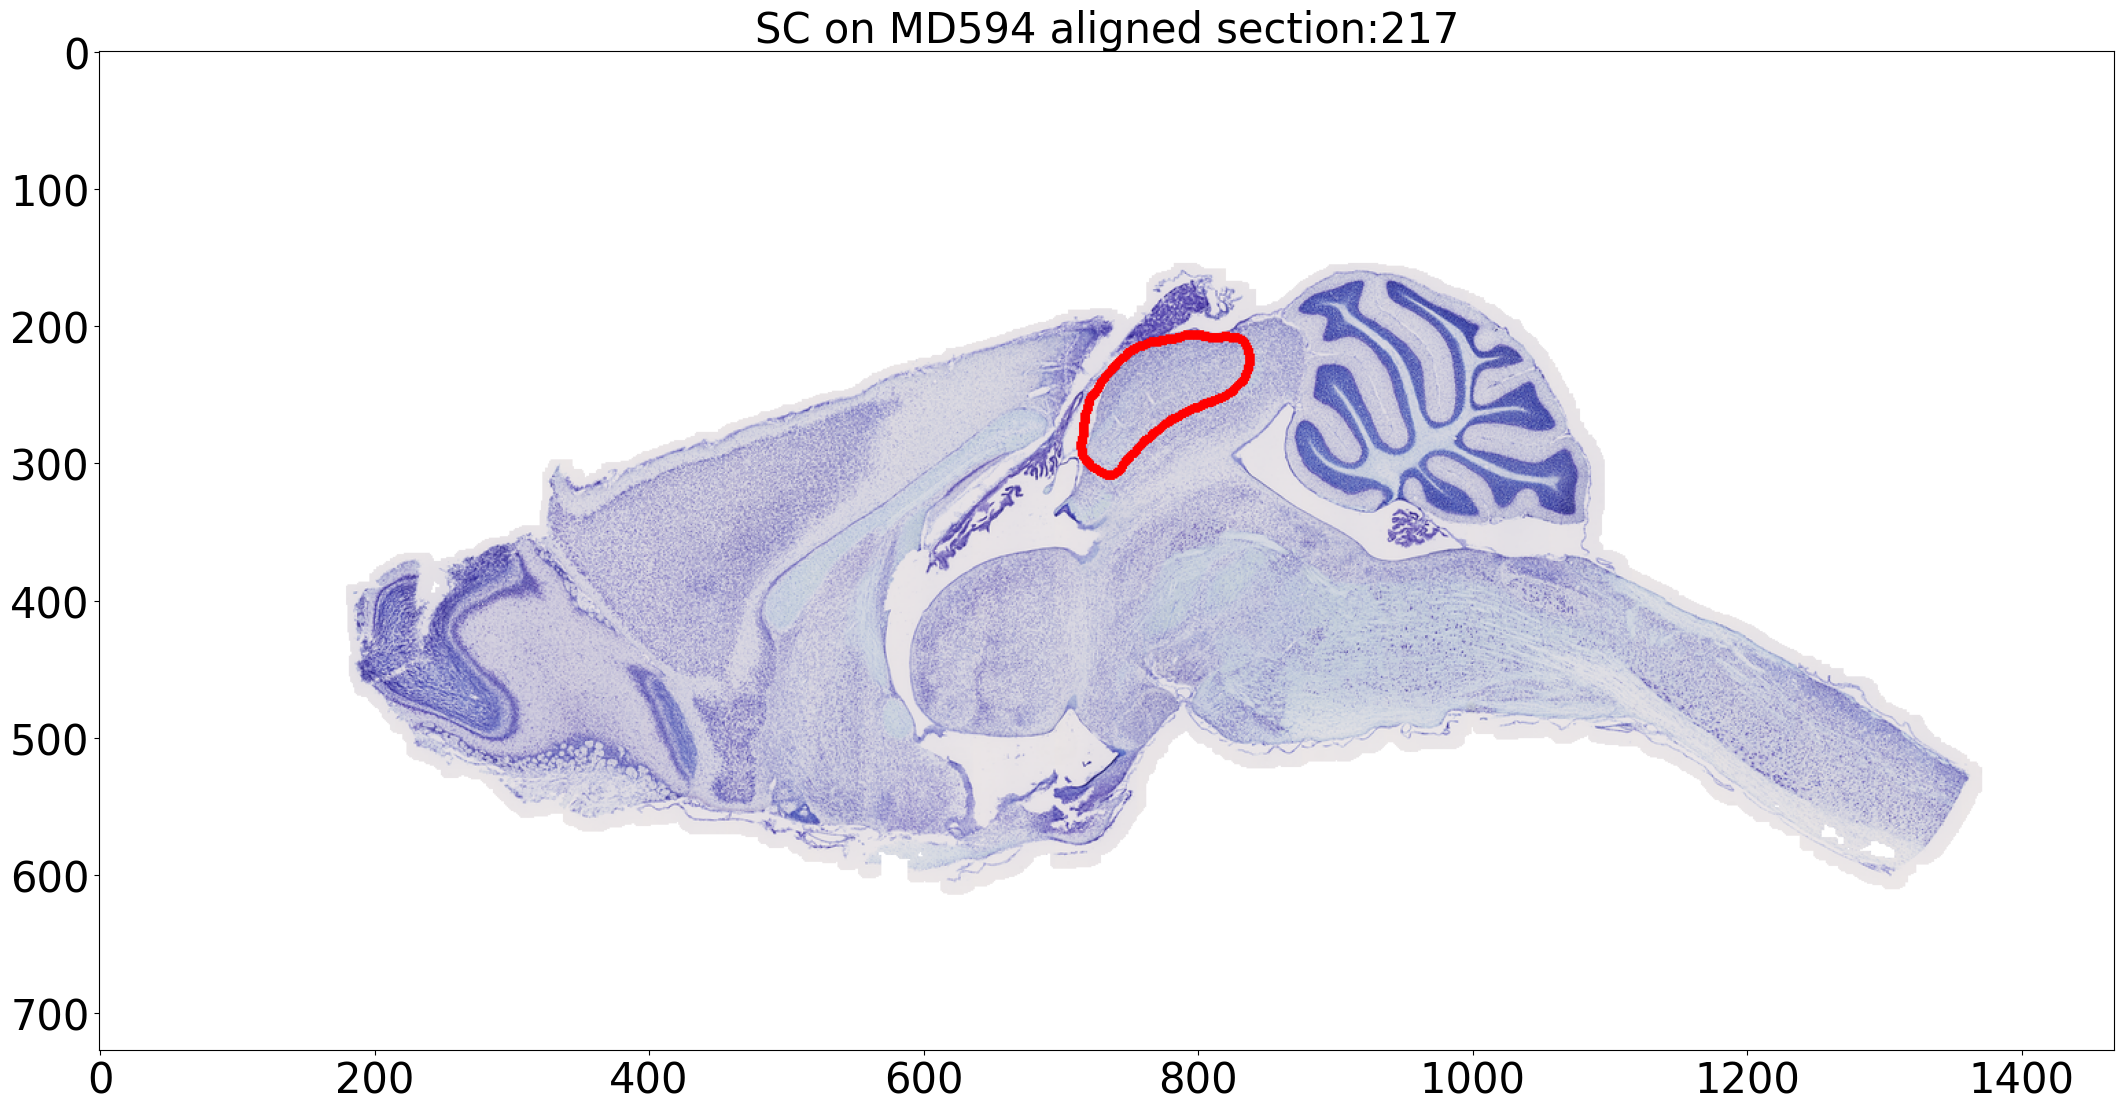

In [11]:
INPUT = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/CH1/thumbnail_aligned'
filepath = os.path.join(INPUT, f'{section}.tif')
img = cv2.imread(filepath)
color = (255,0,0)
cv2.polylines(img, [arr], isClosed=True, color=color, thickness=5)

fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title(f'{structure} on {animal} aligned section:{section}', fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()

In [12]:
padding = 1.1
PADDED_SIZE = (int(ylength*padding), int(xlength*padding))
volume = []
for section, points in sorted(onestructure.items()):
    vertices = np.array(points) - np.array((min_x, min_y))
    volume_slice = np.zeros(PADDED_SIZE, dtype=np.uint8)
    points = (vertices).astype(np.int32)
    volume_slice = cv2.polylines(volume_slice, [points], isClosed=True, color=color, thickness=1)
    volume.append(volume_slice)

volume = np.array(volume)

In [13]:
#v = np.array(volume)
volume.shape

(169, 148, 148)

Text(0.5, 1.0, ' int32')

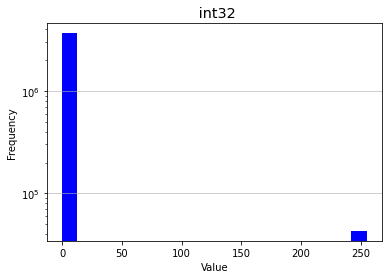

In [14]:
flat = volume.flatten()
fig = plt.figure()
plt.rcParams['figure.figsize'] = [10, 6]
plt.hist(flat, bins=20, color='b')
plt.style.use('ggplot')
plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f' {arr.dtype}')

(169, 148, 148)


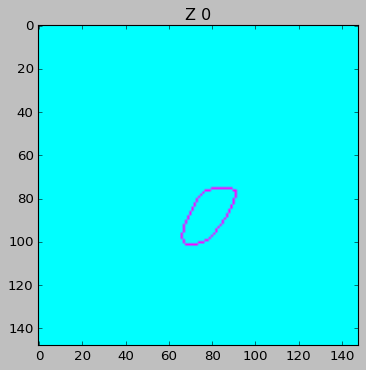

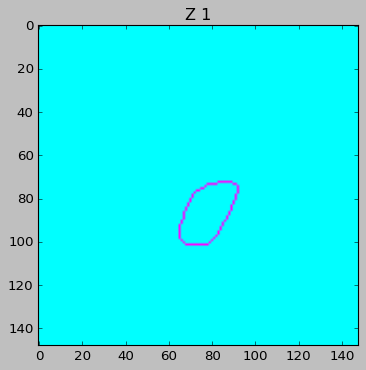

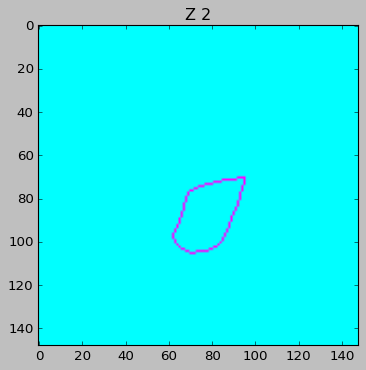

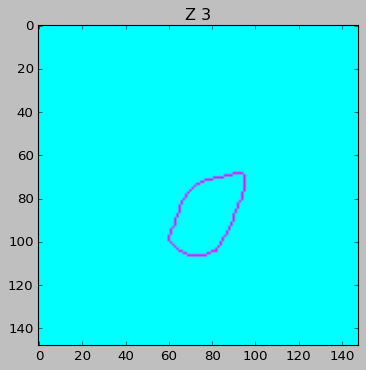

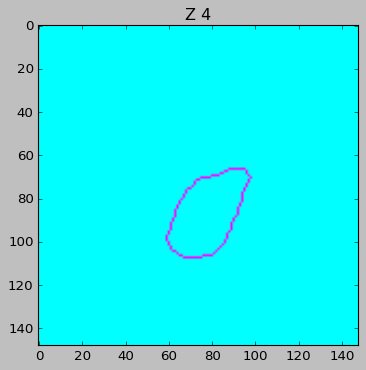

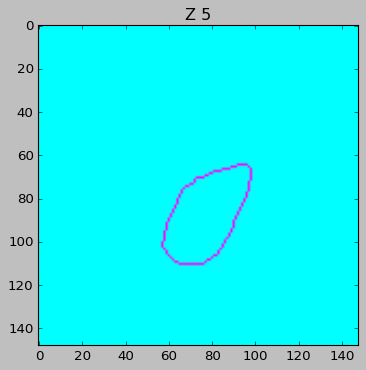

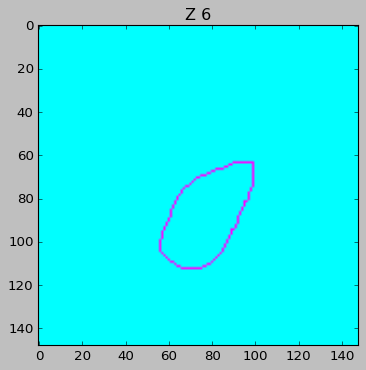

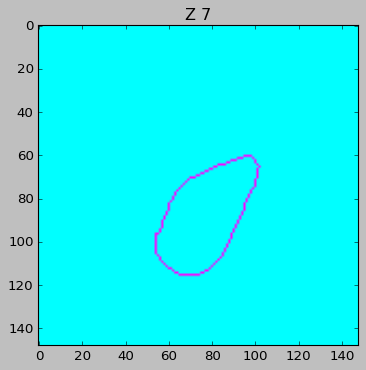

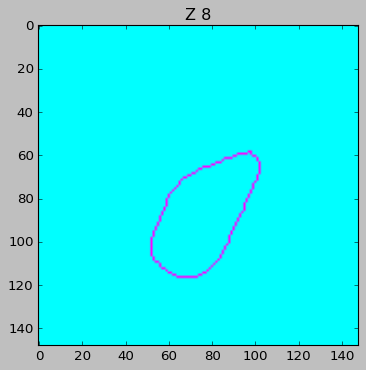

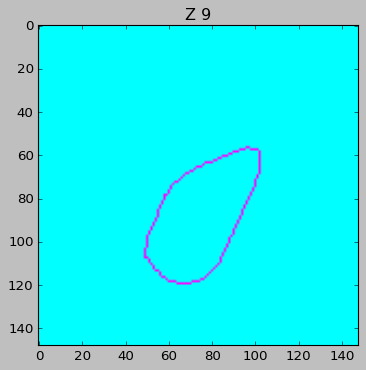

In [15]:
arr = volume.copy()
print(arr.shape)
start = 0
end = start + 10
plt.style.use('classic')
plt.rcParams["figure.figsize"] = (8,5)
for i in range(start, end):
    plt.title('Z {}'.format(i))
    plt.imshow(arr[i,:,:], cmap="cool")
    plt.show()